# Feature Selection

### Load librarires

In [545]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [546]:
path = os.getcwd()
path = path.replace('modeling', 'resources')
files = os.listdir(path)
for file in files:
    if len(file.split('.csv'))>1:
        csv_path = path+'/'+file
data = pd.read_csv(csv_path)

In [547]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Apply cleaning and processing done in data preparation

In [548]:
data['SeniorCitizen']=data['SeniorCitizen'].map({0:'No', 1:'Yes'})
data['TotalCharges']=pd.to_numeric(data.TotalCharges, errors='coerce')
data.drop(data[data.TotalCharges.isna()].index, axis=0, inplace=True)
data.drop('customerID', axis=1, inplace=True)

### Data Overview

In [549]:
data.shape

(7032, 20)

In [550]:
list(data.columns)

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [551]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

In [552]:
all_features = ['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
]

In [553]:
def selected_feature_prediction(data, features):
    X = data[features].copy()
    X.drop(['PhoneService', 'TotalCharges'], axis=1, inplace=True)

    internet_addon_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

    for col in internet_addon_services:
        if col in X.columns:
            X[col] = X[col].replace({'No internet service':'No'})

    cat_columns = X.select_dtypes(include='object').columns
    num_columns = X.select_dtypes(include='number').columns

    y = data['Churn'].replace({'Yes':1, "No":0})
    
    #Train- Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    cat_columns1 = X_train.columns[(X == 'No').any()].to_list() #All these features have a 'No' value which we can target and make 0
    cat_columns2 = cat_columns.drop(cat_columns1)  # We can drop the first column for these features

    drop_no = ['No'] * len(cat_columns1)

    transformer = [('OH1', OneHotEncoder(sparse_output=False, drop=drop_no), cat_columns1), # One-Hot Encode and drop 'No' value features 
                ('OH2', OneHotEncoder(sparse_output=False, drop='first'), cat_columns2), # One-Hot Encode and drop first column
                ('scaler', MinMaxScaler(), num_columns)] # Scale Numerical columns to lie between 0 and 1
    preprocessor = ColumnTransformer(transformer)

    X_train_OH = preprocessor.fit_transform(X_train)
    X_test_OH = preprocessor.transform(X_test)

    feature_names = []
    for name, trans, column in preprocessor.transformers_:
        if hasattr(trans, 'get_feature_names_out'):
            feature_names.extend(trans.get_feature_names_out(column))
        else:
            feature_names.extend(column)

    X_train = pd.DataFrame(X_train_OH, columns=feature_names)
    X_test = pd.DataFrame(X_test_OH, columns=feature_names)

    smote=SMOTE(sampling_strategy='auto', random_state=1)

    X_train, y_train = smote.fit_resample(X_train, y_train)

    # # Convert OH encoded columns that were resampled with SMOTE back to binary
    # OH_encoded_columns = list(set(feature_names)-set(num_columns))
    # threshold = 0.5
    # X_train[OH_encoded_columns] = np.where(X_train[OH_encoded_columns]>threshold, 1, 0)

    ada_clf = AdaBoostClassifier(n_estimators=250, learning_rate=1.3)

    ada_clf.fit(X_train, y_train)
    y_pred = ada_clf.predict(X_test)
    y_pred_proba = ada_clf.predict_proba(X_test)[:,1]

    ada_clf.score(X_test, y_test)

    print(classification_report(y_test, y_pred))

    print(confusion_matrix(y_test, y_pred))

    # ROC AUC Plot

    plt.figure(figsize=(5, 5))

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr,tpr)

    plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.4f}')
        
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Receiver Operating Charactristics")
    plt.legend(loc="lower right")

    #Diagonal Line
    plt.plot([0,1], [0,1], color = 'navy', lw=2, linestyle='--')

    plt.show()

    return ada_clf, X_train, X_test, y_train, y_test

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1033
           1       0.55      0.67      0.60       374

    accuracy                           0.77      1407
   macro avg       0.71      0.73      0.72      1407
weighted avg       0.78      0.77      0.77      1407

[[827 206]
 [124 250]]


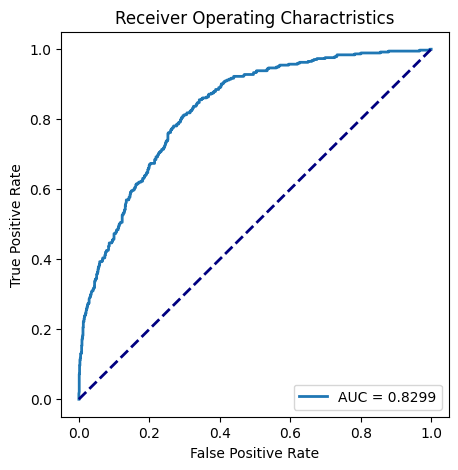

In [554]:
ada_clf, X_train, X_test, y_train, y_test = selected_feature_prediction(data, all_features)
feature_names = X_train.columns.to_list()

In [89]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(ada_clf, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.to_list())

Weight,Feature
0.0613 ± 0.0092,tenure
0.0532 ± 0.0034,InternetService_Fiber optic
0.0173 ± 0.0060,InternetService_DSL
0.0102 ± 0.0074,Contract_One year
0.0085 ± 0.0077,Contract_Two year
0.0057 ± 0.0031,MonthlyCharges
0.0043 ± 0.0027,OnlineBackup_Yes
0.0043 ± 0.0052,PaymentMethod_Electronic check
0.0043 ± 0.0099,PaperlessBilling_Yes
0.0038 ± 0.0045,Dependents_Yes


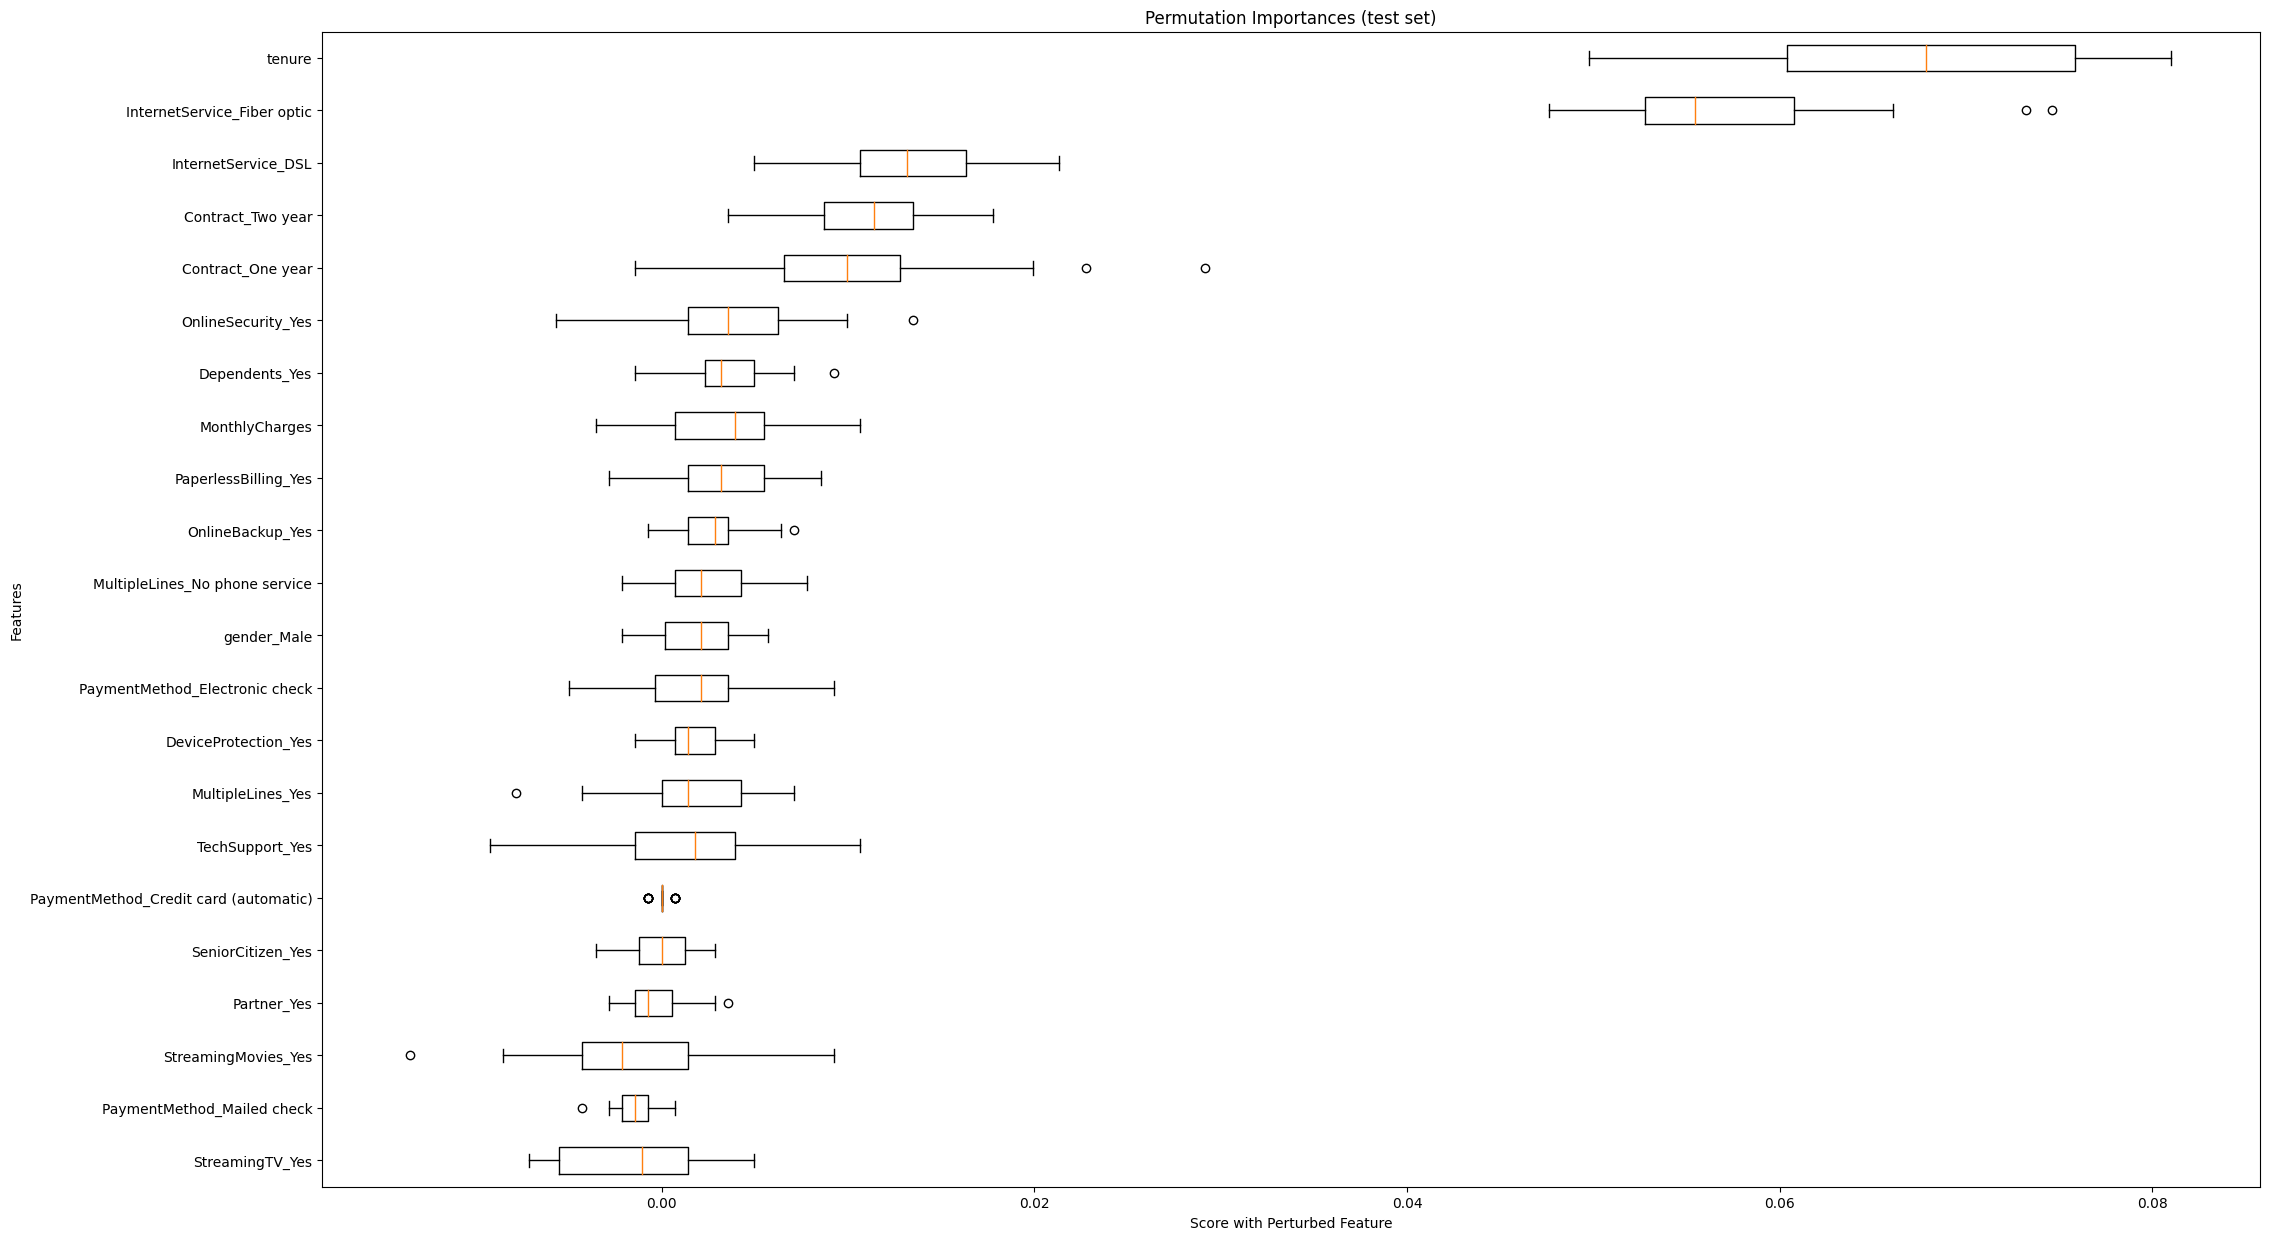

              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1041
           1       0.53      0.79      0.63       366

    accuracy                           0.76      1407
   macro avg       0.72      0.77      0.73      1407
weighted avg       0.81      0.76      0.77      1407

[[782 259]
 [ 78 288]]


In [90]:
from sklearn.inspection import permutation_importance

result = permutation_importance(ada_clf, X_test, y_test, n_repeats=30, random_state=1)

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(25, 15))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Importances (test set)")
plt.xlabel("Score with Perturbed Feature")
plt.ylabel("Features")
plt.show()

# Selecting features with importance above a threshold
threshold = 0.01  # You can choose the threshold based on the plot or other criteria
important_features = np.array(feature_names)[result.importances_mean > threshold]

# You can then train your model using only the selected important features
X_train_imp = X_train[important_features]
X_test_imp = X_test[important_features]

ada_clf2 = AdaBoostClassifier(n_estimators=250, learning_rate=1.3)
# Fit the model with the important features
ada_clf2.fit(X_train_imp, y_train)

# Test the model with the important features
y_pred_imp = ada_clf2.predict(X_test_imp)

# Evaluate the model
print(classification_report(y_test, y_pred_imp))
print(confusion_matrix(y_test, y_pred_imp))

In [91]:
select_features_1 = ['gender',
 'SeniorCitizen',
# 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
#'StreamingTV',
# 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
]

              precision    recall  f1-score   support

           0       0.90      0.81      0.86      1041
           1       0.59      0.75      0.66       366

    accuracy                           0.80      1407
   macro avg       0.74      0.78      0.76      1407
weighted avg       0.82      0.80      0.80      1407

[[848 193]
 [ 92 274]]


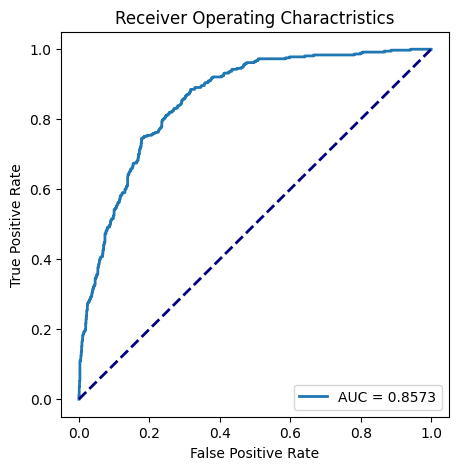

In [92]:
ada_clf3, X_train3, X_test3, y_train3, y_test3 = selected_feature_prediction(data, select_features_1)

In [93]:
select_features_2 = ['gender',
 'SeniorCitizen',
'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
'StreamingTV',
# 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
]

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      1041
           1       0.59      0.73      0.65       366

    accuracy                           0.80      1407
   macro avg       0.74      0.78      0.75      1407
weighted avg       0.82      0.80      0.80      1407

[[857 184]
 [100 266]]


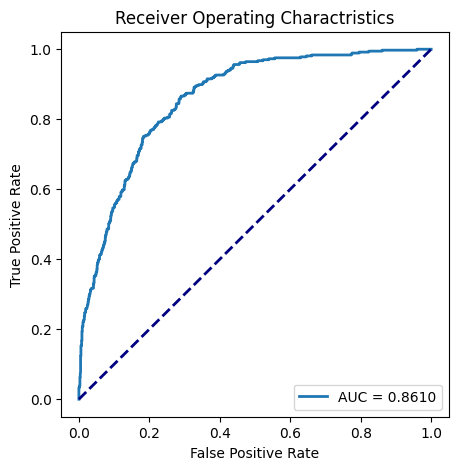

In [94]:
ada_clf3, X_train3, X_test3, y_train3, y_test3 = selected_feature_prediction(data, select_features_2)

The differences observed are pretty small and it would be better to include all features for predicting Churn